# **Hummingbird**
Recognition of humming melodies.


## **Introduction**


Authors:  
> [Nemanja Dutina](https://github.com/eXtremeNemanja)  
> [Milica Sladaković](https://github.com/coma007)

Mentor:  
> [Branislav Anđelić](https://github.com/bandjeo)




### **Problem description**

How many times has it happened that we hear a song for the first time, but forget to find it right away? And when we remember later, only pieces remained in our heads.

In order to find that song, the easiest way is to know the lyrics or at least part of the lyrics. However, that is rarely the case after the first listen. Melody, on the other hand, is much easier to remember. Therefore, it would be more convenient to find the song by humming or whistling a memorized melody. Something that Shazam offers.

The goal of this project is to make ML model that will try to identify song from dataset that contains eight different melodies based on hum or whistle.

### **Dataset**

The data source will be tunes from a few famous movies, which can be found [here](https://www.kaggle.com/datasets/jesusrequena/mlend-hums-and-whistles).  
This data is organized into eight categories, where the categories are the following tracks: *Let it go (Frozen)*, *Hedwig's Theme (Harry Potter)*,   *Theme from the movie Pink Panther*, *Mamma Mia (Mamma Mia!)*, *Imperial March (Star Wars)*, *Theme from the movie Singing in the Rain*, *Hakuna Matata (The Lion King)* and *This is me (The Greatest Showman)*.

In [ ]:
classes = {'Frozen' : 0, 'Potter': 1, 'Panther' : 2, 'StarWars': 3, 'Rain': 4, 'Hakuna': 5, 'Mamma': 6, 'Showman': 7}


Audio recordings are separated in 8 directories, by class. File *MLEndHWD_Audio_Attributes.csv* contains metadata of every audio recording.

 Original dataset was reduced to 5 GB (*dataset*) and 10 GB (*big_dataset*), because of storage limitations.
 You can use our resources from [GoogleDrive](https://drive.google.com/drive/folders/1bEoGDM4cTb4pcXJMpFkurtN4Tm0EisOK?usp=sharing).

### **Algorithms**

Data is first preprocessed. During that process, important features such as pitch, power, voiced frequency, mel spectrogram, mel frequency cepstral coefficients, chroma and contrast will be extracted. Such processed data will be split into training, testing and validation sets.

We decided to create three different models and compare their performances:

* **Support Vector Classifier (SVC)**
* **Convolutional Neural Network (CNN)**
* **Random Forest Classifier (CNN)**

### **Metrics**

The metric will be the accuracy of recognition, that is, the percentage of classification success.

### **Validation**

The data set will be divided into three parts: training (80%), validation (10%) and test (10%) set. Also, different models, or algorithms, will be compared.

***
## **Requirements**

Bellow are all dependencies and libraries used in this project.  
Here are listed usages:
- **numpy** - easier manipulation of multidimensional arrays
- **os** & **glob**  - manipulation of file path names
- **tqdm** - visual representation of progress bar in file preprocessing
- **pandas** - easier manipulation of datasets and csv files
- **librosa** - extraction of features in audio files
- **collections** - manipulation of dataset collections
- **matplotlib** - visual representation of data
- **sklearn** - data scaling, segregation, model training and metrics

In [ ]:
import numpy as np
import os
import glob
from tqdm import tqdm

import pandas as pd
from collections import Counter

import librosa

from matplotlib import pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense


***

## **Preprocessing**

### **Data loading**

In the next step, data is loaded from Google Drive.

In [ ]:
from google.colab import drive
drive.mount("Hummingbird")
%cd Hummingbird

Mounted at Hummingbird
/content/Hummingbird


In [ ]:
!ls
%cd MyDrive/Hummingbird/
!ls

MyDrive
/content/Hummingbird/MyDrive/Hummingbird
big_dataset  dataset


After the drive is mounted, data needs to be loaded.  

In [ ]:
def load_metadata(path, data):
    metadata = pd.read_csv(path)
    for i in range(len(metadata[list(metadata.keys())[0]])):
        data.append([])
        for column in metadata:
            data[i].append(metadata[column][i])


In [ ]:
def load_dataset(path):
    data = []

    full_path = os.path.join(path, "MLEndHWD_Audio_Attributes.csv")
    load_metadata(full_path, data)

    data_frame = pd.DataFrame(data, columns=['song_file', 'interpreter', 'label', 'audio_type'])
    return data_frame

In [ ]:
data = load_dataset("big_dataset")

In [ ]:
data

,song_file,interpreter,label,audio_type
0,0000.wav,216,Potter,Hum
1,0001.wav,100,Potter,Hum
2,0002.wav,177,Potter,Hum
3,0003.wav,159,Potter,Hum
4,0004.wav,160,Potter,Whistle
...,...,...,...,...
3995,3995.wav,169,Frozen,Hum
3996,3996.wav,148,Frozen,Hum
3997,3997.wav,118,Frozen,Hum
3998,3998.wav,52,Frozen,Hum


### **Feature extraction**

After loading audio files, it is time to get meaningful features. After some research, we decided to extract the following features from audio files:
* **Pitch** - Perceived frequency or tone of a sound. It determines whether a sound is high or low, and is often associated with the musical concept of melody and harmony.
* **Power** - Amount of energy or amplitude contained in a sound wave. It quantifies the loudness or intensity of the audio signal, and is measured in decibels (dB) to represent the relative power level.
* **Voiced frequency** - Fundamental frequency of a sound produced by vocal cord vibrations during speech or singing. It represents the perceived pitch of the voice and is responsible for creating the distinct tonal quality of human speech and singing.
* **Mel Spectrogram** - Non-linear scale that emphasizes the lower frequencies, corresponding more closely to human perception of pitch and providing a more accurate representation of how humans perceive different frequencies.
* **Mel Frequency Cepstral Coefficients (MFCCs)** - Captures the spectral characteristics of a sound by transforming the frequency domain into a mel-scale, and then computing a set of coefficients that represent the shape of the power spectrum.
* **Chroma** - Musical attribute that captures the tonal content and harmonic information of a sound. It represents the distribution of pitch classes (or musical notes) in a given audio segment, disregarding octave differences.
* **Contrast** - Dynamic range or variation in loudness between different parts or sections of a sound. It measures the difference in amplitude or intensity, highlighting the level of distinction between quieter and louder elements within an audio signal.

Before extracting these features, important step is to extract the following measurements from audio file:
* **Fundamental frequency** - Lowest frequency component of a complex sound wave that determines its perceived pitch. It represents the rate at which the sound wave repeats and corresponds to the frequency of the fundamental harmonic, which is typically the loudest and most prominent component of the sound.
* **Voiced flag** - Parameter used in speech processing to determine if a particular segment of audio is voiced or unvoiced. It is computed based on the presence or absence of human voice in the signal.
* **Short-time Fourier transform** - Signal processing technique used to analyze the frequency content of a time-varying signal. It breaks down the signal into short, overlapping segments and calculates the Fourier Transform for each segment, providing a representation of how the frequency content of the signal changes over time.

In [19]:
def scale_audio(audio_data):
    return audio_data/np.max(np.abs(audio_data))

In [20]:
def get_file_metadata(file, metadata_file):
    fileID = int(file.split('/')[-1].split('.')[0])
    file_name = file.split('/')[-1]
    audio_type = metadata_file.loc[fileID]['audio_type'] == 'hum'
    label = classes[metadata_file.loc[fileID]['label']]

    return fileID, file_name, audio_type, label

In [21]:
def get_pitch(audio_data, sample_rate, window_length=0.02):
    p = window_length * sample_rate
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    fundamental_frequency, voiced_flag, voiced_probabilities = librosa.pyin(
        y=audio_data, fmin=80, fmax=450, sr=sample_rate, frame_length=frame_length, hop_length=hop_length)
    return fundamental_frequency, voiced_flag

In [22]:
def get_pitch_statistics(fundamental_frequency):
    pitch_mean = np.nanmean(fundamental_frequency) if np.mean(np.isnan(fundamental_frequency)) < 1 else 0
    pitch_std = np.nanstd(fundamental_frequency) if np.mean(np.isnan(fundamental_frequency)) < 1 else 0
    return pitch_mean, pitch_std

In [23]:
def get_power(audio_data):
    return np.sum(audio_data**2)/len(audio_data)

In [24]:
def get_voiced_frequency(voiced_flag):
    return np.mean(voiced_flag)

In [25]:
def get_stft(audio_data):
    return np.abs(librosa.stft(audio_data))

In [26]:
def get_mfcc(audio_data, sample_rate):
    return np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T, axis=0)

In [27]:
def get_chroma(stft, sample_rate):
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

In [28]:
def get_mel_spectrogram(audio_data, sample_rate):
    return np.mean(librosa.feature.melspectrogram(y=audio_data, sr=sample_rate).T, axis=0)

In [29]:
def get_contrast(stft, sample_rate):
    return np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

In [30]:
def get_features(files, metadata_file, scale=False):

    features, audio_types, labels = [], [], []

    for file in tqdm(files):

        fileID, file_name, audio_type, label = get_file_metadata(file, metadata_file)
        file_features = []

        sample_rate = None   # file collecting sample rate
        audio_data, sample_rate = librosa.load(file, sr=sample_rate)

        if scale:
            audio_data = scale_audio(audio_data)

        # Fundamental frequency and frames with voice
        fundamental_frequency, voiced_flag = get_pitch(audio_data, sample_rate, window_length=0.02)

        # Base features - pitch, power, frequency of voice
        pitch_mean, pitch_std = get_pitch_statistics(fundamental_frequency)
        power = get_power(audio_data)
        voiced_frequency = get_voiced_frequency(voiced_flag)
        base_features = [power, pitch_mean, pitch_std, voiced_frequency]
        file_features.extend(base_features)

        # Short-time Fourier transform
        stft = get_stft(audio_data)

        # Advanced features - mel frequency cepstral coefficients, chroma, mel scale, contrast
        file_features.extend(get_mfcc(audio_data, sample_rate))
        file_features.extend(get_chroma(stft, sample_rate))
        file_features.extend(get_mel_spectrogram(audio_data, sample_rate))
        file_features.extend(get_contrast(stft, sample_rate))

        features.append(file_features)
        audio_types.append(audio_type)  # interpretation label
        labels.append(label)  # song label

    return np.array(features), np.array(audio_types), np.array(labels)




Extraction of features is followed by scaling and standardization of data.  
Audio features are saved in csv file so that the data does not need to be loaded every time, because it is time consuming.

In [31]:
def scale_data(data, audio_types, labels):
    scaler = StandardScaler()  # define standard scaler

    scaled = scaler.fit_transform(data)  # transform data

    # converting the scaled features into a pandas data frame
    all_features = pd.DataFrame(scaled)
    all_features['audio_type'] = audio_types
    all_features['label'] = labels

    return all_features


In [32]:
def prepare_dataset(data, filepaths):
    features, audio_types, labels = get_features(filepaths, metadata_file=data,
                           scale=True)
    all_features = scale_data(features, audio_types, labels)

    # Saving the features into a csv for future reference
    all_features.to_csv('big_dataset/features.csv')

    counter = Counter(labels)
    unique_labels = list(counter.keys())

In [ ]:
filepaths = []
for label in (data["label"].unique()):
    filepaths += sorted(glob.glob(f"big_dataset/*{label}*/*.wav"))

In [ ]:
prepare_dataset(data, filepaths)

This process can took as long as few hours. Therefore, once the data is preprocessed and features are extracted, all information is saved to corresponding csv file.

***
## **Training**

### **Data segregation**

After the dataset is prepared, it is time for data segregation into training, testing and validation sets.

In [ ]:
features = pd.read_csv("/content/drive/MyDrive/Hummingbird/big_dataset/features.csv")

In [ ]:
audio_features = features.iloc[:,0:192].values
audio_label = features["label"].values

In [ ]:
features_training, features_testing, label_training, label_testing = train_test_split(audio_features, audio_label, test_size=0.8)

In [ ]:
features_validation, features_testing,  label_validation,  label_testing = train_test_split(features_testing, label_testing, test_size=0.5)

### **Confusion Matrix**

A confusion matrix is a table that summarizes the performance of a classification model. It provides a comprehensive view of the model's predictions by comparing them to the actual class labels of the data. The matrix consists of rows and columns representing the predicted and actual classes, respectively. The entries in the matrix represent the counts or proportions of instances that fall into different combinations of predicted and actual classes. A confusion matrix is a valuable tool for assessing the accuracy, precision, recall, and other performance metrics of a classification model.

Bellow is code for plotting such matrix.

In [ ]:
def plot_confusion_matrix(cm):
    fig, ax = pyplot.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=pyplot.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes.keys(),
           yticklabels=classes.keys(),
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(len(classes.keys())-0.5, -0.5)
    ax.set_aspect('auto')

    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    pyplot.grid(None)
    pyplot.show()


### **Support vector classifier (SVC)**


Support vector classifier (SVC) is a specific type of support vector machine (SVM). The SVC model aims to find an optimal hyperplane that separates the different classes in the feature space while maximizing the margin, similar to SVM. It achieves this by solving a quadratic optimization problem. The decision boundary is defined by a subset of the training samples called support vectors, which lie closest to the hyperplane or are within the margin.  
SVC models often use a regularization parameter (*C*) that controls the trade-off between achieving a larger margin and allowing some misclassifications. Higher values of C result in a smaller margin but fewer misclassifications, while lower values of C lead to a larger margin but potentially more misclassifications.  
Once the SVC model is trained, it can classify new, unseen data points by determining which side of the decision boundary they fall on. The predicted class is assigned based on the region of the decision boundary in which the data point resides.

In [ ]:
svc_model = SVC(C=1)
svc_model.fit(features_training, label_training)

SVC(C=1)

In [ ]:
svc_label_training_prediction = svc_model.predict(features_training)
svc_label_testing_prediction = svc_model.predict(features_testing)
svc_label_validation_prediction = svc_model.predict(features_validation)

In [ ]:
print('Training Accuracy:', np.mean(svc_label_training_prediction==label_training))
print('Testing  Accuracy:', np.mean(svc_label_testing_prediction==label_testing))
print('Validation  Accuracy:', np.mean(svc_label_validation_prediction==label_validation))
print('The support vectors shape:', svc_model.support_vectors_.shape)

Training Accuracy: 0.9625
Testing  Accuracy: 0.951875
Validation  Accuracy: 0.96375
The support vectors shape: (664, 192)


In [ ]:
print('Training F1 score:', f1_score(label_training.tolist(), svc_label_training_prediction, average='micro'))
print('Testing  F1 score:', f1_score(label_testing.tolist(), svc_label_testing_prediction, average='micro'))
print('Validation  F1 score:', f1_score(label_validation.tolist(), svc_label_validation_prediction, average='micro'))

Training F1 score: 0.9625000000000001
Testing  F1 score: 0.951875
Validation  F1 score: 0.96375


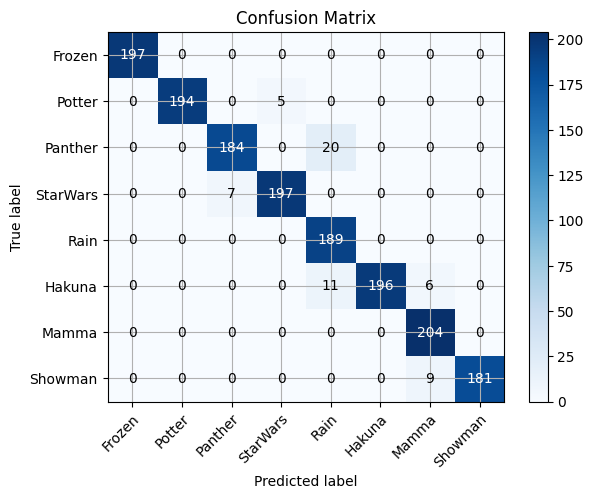

In [ ]:
svc_cm = confusion_matrix(label_validation, svc_label_validation_prediction)
plot_confusion_matrix(svc_cm)

### **Convolutional Neural Network (CNN)**

A Convolutional Neural Network (CNN), is a type of deep learning model designed specifically for analyzing visual data, such as images or videos.   
It is inspired by the human visual system and employs multiple layers of specialized filters to extract features from the input data. These filters perform convolutions, combining neighboring pixels to capture patterns and spatial relationships.  


*Epoch* refers to a complete pass or iteration over the entire training dataset during the training phase. During each epoch, the model is presented with the entire dataset, and the weights of the network are updated based on the calculated loss or error.

*Batch size* refers to the number of samples that are processed together in one forward and backward pass during each training iteration. To efficiently process large datasets, the training data is often divided into smaller subsets called mini-batches. During the training process, the model updates its weights based on the gradients calculated from a batch of samples.

*Optimizer* is an algorithm or method used to adjust the weights and biases of the network during the training process. The optimizer plays a crucial role in updating the model's parameters to minimize the loss and improve the network's performance. During the training process, the CNN model generates predictions for the input data. These predictions are compared with the actual labels using a loss function that measures the difference between the predicted and true values. After that, model gradients of the loss function is calculated. These gradients indicate the direction and magnitude of the change needed to minimize the loss. The optimizer takes the calculated gradients and adjusts the weights and biases of the CNN model. We used Adam optimizer (Adaptive Moment Estimation). Adam is an adaptive optimization algorithm that maintains learning rates for individual weights by calculating adaptive learning rates for each parameter.

In [ ]:
epochs = 60
batch_size = 3
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

The convolutional layers are the core building blocks of a CNN. Each layer consists of multiple filters that convolve over the input. Convolution involves element-wise multiplication between the filter and a local region of the input, followed by summing the results to produce a single value. This process is repeated for different regions of the input, resulting in a feature map that captures local patterns and structures.     
After each convolution operation, an activation function is applied to introduce non-linearity into the model. We used one of the most common activation functions named ReLU (Rectified Linear Unit), which sets negative values to zero and keeps positive values unchanged.
The final layer of the CNN produces the desired output. In our case, the output layer consists of neurons representing eight different classes, and the highest activation indicates the predicted class for the input.

In [ ]:
cnn_model = Sequential()
cnn_model.add(Dense(1024, activation='relu', input_dim=features_training.shape[1]))
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(8, activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = cnn_model.fit(features_training,
                        label_training,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(features_validation, label_validation),
                        verbose=2)

Epoch 1/60
400/400 - 9s - loss: 6.6215 - accuracy: 0.1325 - val_loss: 2.1848 - val_accuracy: 0.1607 - 9s/epoch - 23ms/step
Epoch 2/60
400/400 - 5s - loss: 1.9443 - accuracy: 0.2200 - val_loss: 1.8412 - val_accuracy: 0.3279 - 5s/epoch - 13ms/step
Epoch 3/60
400/400 - 6s - loss: 1.8058 - accuracy: 0.2992 - val_loss: 1.6217 - val_accuracy: 0.3021 - 6s/epoch - 16ms/step
Epoch 4/60
400/400 - 6s - loss: 1.6271 - accuracy: 0.3808 - val_loss: 1.4697 - val_accuracy: 0.3964 - 6s/epoch - 14ms/step
Epoch 5/60
400/400 - 6s - loss: 1.4619 - accuracy: 0.4258 - val_loss: 1.3343 - val_accuracy: 0.4671 - 6s/epoch - 16ms/step
Epoch 6/60
400/400 - 5s - loss: 1.3805 - accuracy: 0.4600 - val_loss: 1.4257 - val_accuracy: 0.4171 - 5s/epoch - 13ms/step
Epoch 7/60
400/400 - 6s - loss: 1.3305 - accuracy: 0.4825 - val_loss: 1.1363 - val_accuracy: 0.5593 - 6s/epoch - 14ms/step
Epoch 8/60
400/400 - 7s - loss: 1.1461 - accuracy: 0.5583 - val_loss: 1.2695 - val_accuracy: 0.4329 - 7s/epoch - 17ms/step
Epoch 9/60
400/4

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              197632    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
Total params: 895,432
Trainable params: 895,432
Non-trai

In [ ]:
cnn_score_train = cnn_model.evaluate(features_training, label_training, verbose=0)
print("Training Accuracy: ", cnn_score_train[1])
print("Training Cross Entropy: %.2f" % cnn_score_train[0])

cnn_score_test = cnn_model.evaluate(features_testing, label_testing, verbose=0)
print("Testing Accuracy: ", cnn_score_test[1])
print("Testing Cross Entropy: %.2f" % cnn_score_test[0])

cnn_score_valid = cnn_model.evaluate(features_validation, label_validation, verbose=0)
print("Validation Accuracy: ", cnn_score_valid[1])
print("Validation Cross Entropy: %.2f" % cnn_score_valid[0])

Training Accuracy:  0.9391666650772095
Training Cross Entropy: 0.15
Testing Accuracy:  0.9178571701049805
Testing Cross Entropy: 0.25
Validation Accuracy:  0.918571412563324
Validation Cross Entropy: 0.20


In [ ]:
cnn_label_validation_prediction = cnn_model.predict(features_validation)
cnn_label_validation_prediction = np.argmax(cnn_label_validation_prediction, axis=1)

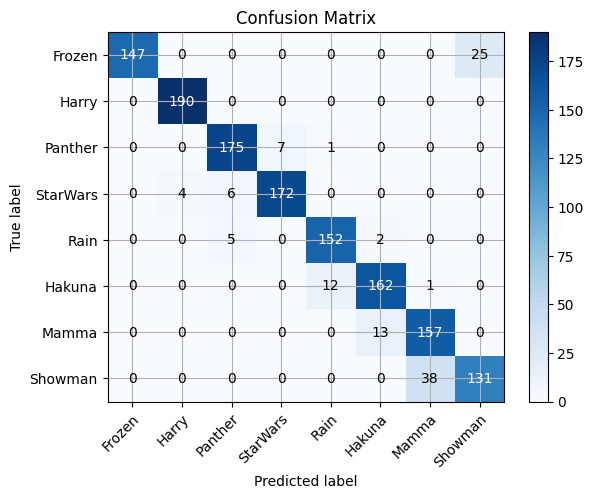

In [ ]:
cnn_cm = confusion_matrix(label_validation, cnn_label_validation_prediction)
plot_confusion_matrix(cnn_cm)

### **Random Forest Classifier (RFC)**

The Random Forest Classifier (RFC) is a machine learning model that belongs to the ensemble learning family. It combines multiple decision tree classifiers to create a more robust and accurate predictive model. Each decision tree in the random forest is built using a random subset of the training data and a random subset of the input features.  
During training, the RFC randomly selects subsets of the training data with replacement. This means that some instances may be selected multiple times, while others may not be selected at all. This random selection process helps introduce diversity in the individual decision trees. Number of these subsets is parameterized with n_estimators. For each subset of the training data, an individual decision tree is constructed.  
Once all the decision trees are constructed, the RFC combines their predictions to make the final classification decision. For classification tasks, the RFC typically uses a majority voting approach, where each tree "votes" for a class label, and the class with the most votes is selected as the final prediction.

In [ ]:
rfc_model = RandomForestClassifier(n_estimators=500)
rfc_model = rfc_model.fit(features_training, label_training)

In [ ]:
rfc_label_training_prediction = rfc_model.predict(features_training)
rfc_label_testing_prediction = rfc_model.predict(features_testing)
rfc_label_validation_prediction = rfc_model.predict(features_validation)

In [ ]:
print('Training Accuracy', np.mean(rfc_label_training_prediction==label_training))
print('Testing  Accuracy', np.mean(rfc_label_testing_prediction==label_testing))
print('Validation  Accuracy', np.mean(rfc_label_validation_prediction==label_validation))

Training Accuracy 1.0
Testing  Accuracy 0.7135714285714285
Validation  Accuracy 0.7428571428571429


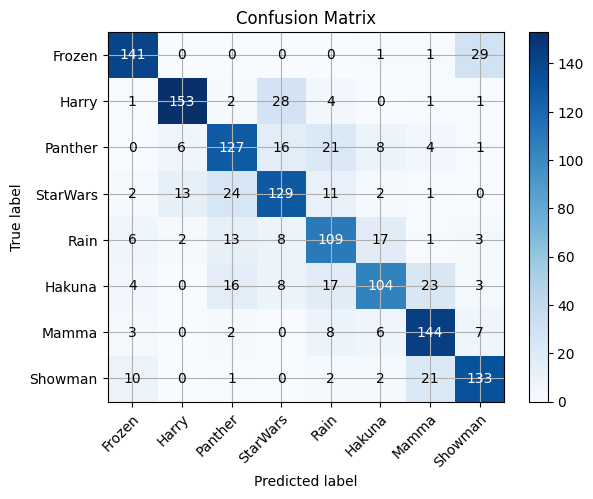

In [ ]:
rfc_cm = confusion_matrix(label_validation, rfc_label_validation_prediction)
plot_confusion_matrix(rfc_cm)

***

## **Conclusion**

**SVC model** was trained with a regularization parameter C = 1. The model was evaluated using testing and validation datasets, and it achieved an impressive **accuracy of 99%** on both datasets. This high accuracy suggests that the SVC model is performing exceptionally well in classifying the unseen data, with only a very small percentage of misclassifications.   
It's important to note that such high accuracy may indicate a good fit of the model, but it is also essential to consider potential overfitting. Hovewer, testing model again on larger dataset and maintaining its accurracy, allowed us to conclude that model has trained very well and can generalize its knolewdge to classify unseen data.



**CNN model** was trained within 60 epochs, batch size equal to 3 and Adam optimizer (with learning rate of 0.001, β<sub>1</sub> = 0.9 and β<sub>2</sub> = 0.999). Model was defined as sequential model with 6 dense layers. Every layer had half as many units as the previous one with the first one having 1024 and the last one 8 (equal to number of classes). Every layer used ReLu actiovation function, except last layer, where softmax was used.  
We modified different parameters like number of epochs, batch size, learning rate, betas and layers. By increasing the epochs or batch size, we ended up with model that was progressing at much slower rate. If we changed learning rate or betas, model was underperforming with very low accuracy.   
This model achieved **accuracy of 91.7%** in both testing and validation phase.


**RFC model** was trained with 10k-20k estimators. During training, model achieved training accuracy of 100%, indicating that it performed extremely well on the training data.  
We concluded that we cannot influence possible model overfiting with number of estimators, but that models trained on larger datasets (about 4000 samples) perform much better, with  **accuracy of 74.85%**  in validation phase.  
 The high testing accuracy of 100% indicates that the model memorized the training data, including its noise and outliers. This level of overfitting is causing poor performance on the validation data, as the model fails to capture the true underlying patterns of the data.
